# Environment Init

In [97]:
import matplotlib.pyplot as plt
import matplotlib.figure
import os
import wordcloud
import scipy.io
from statsmodels.tsa.seasonal import STL, DecomposeResult
import pandas as pd

if not os.path.exists("./report/figures/"):
  os.makedirs("./report/figures")

# Water dataset
## Import variables

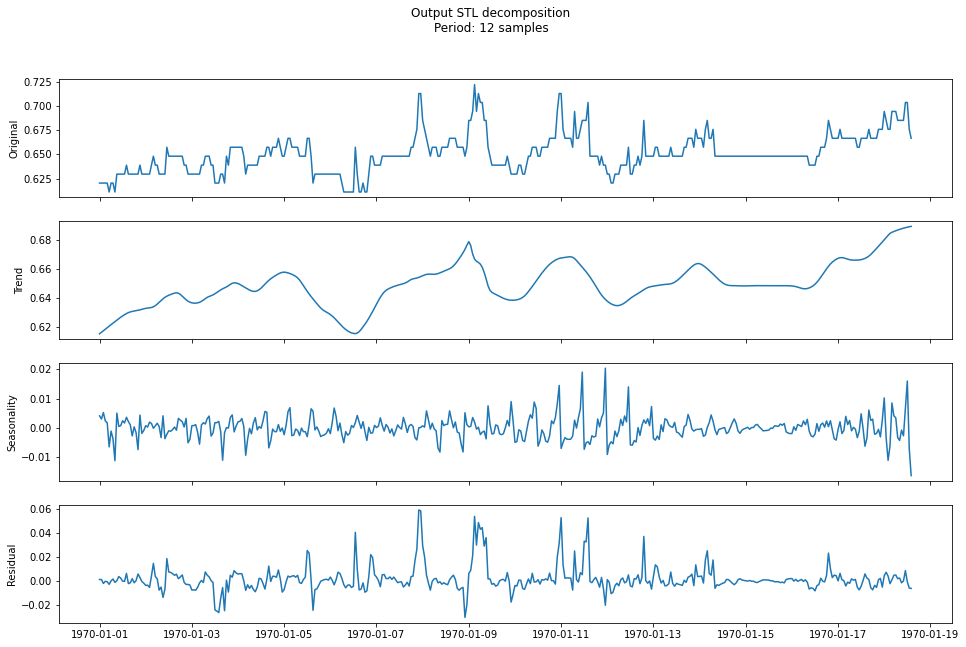

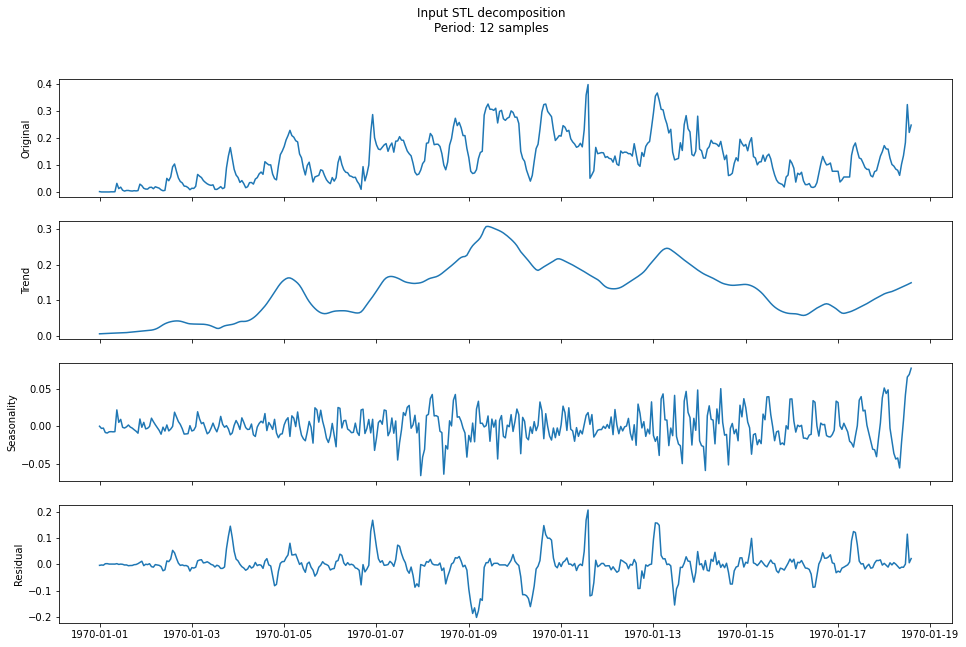

In [98]:
water_dataset = scipy.io.loadmat("./WaterQualityData.mat")
period = 12
N = water_dataset["Ydata"].shape[0]
x_data = pd.Series(water_dataset["Xdata"][:,0],
                   index=pd.date_range(start=0, periods=N, freq="H"))
y_data = pd.Series(water_dataset["Ydata"][:,0],
                   index=pd.date_range(start=0, periods=N, freq="H"))

def stl_custom_plot(stl:DecomposeResult, suptitle:str, save_path:str,
                      figsize:tuple[int,int]=(16,10)
                    )-> matplotlib.figure.Figure:
  fig = plt.figure(figsize=figsize)
  axes = fig.subplots(4,1, sharex=True)
  axes[0].plot(stl.observed); axes[0].set_ylabel("Original")
  axes[1].plot(stl.trend); axes[1].set_ylabel("Trend")
  axes[2].plot(stl.seasonal); axes[2].set_ylabel("Seasonality")
  axes[3].plot(stl.resid); axes[3].set_ylabel("Residual")
  axes[3].autoscale(enable=True, axis="x", tight=True)
  fig.suptitle(suptitle)
  fig.savefig(fname=save_path)

  return fig;

stl_x = STL(x_data, period=period, robust=True).fit()
fig = stl_custom_plot(stl_x,
                      f"Input STL decomposition\nPeriod: {period} samples",
                      "./report/figures/x_decomp.eps")

stl_y = STL(y_data, period=period, robust=True).fit()
fig = stl_custom_plot(stl_y,
                      f"Output STL decomposition\nPeriod: {period} samples",
                      "./report/figures/y_decomp.eps")